In [1]:
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from utils import *
import torch
import torch.utils.data as Data

sns.set_style("white")

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--path', type = str, default = 'input\Gold Price.csv')
parser.add_argument('--label', type = str, default = 'USD (PM)')

parser.add_argument('--seq_size', type = float, default = 20)

parser.add_argument('--epochs', type = int, default = 500)
parser.add_argument("--lr", type=float, default = 0.0005)

parser.add_argument('--batch_size', type = int, default = 256)

parser.add_argument('--layer_size', type = int, default = 1)
parser.add_argument('--input_size', type = int, default = 8)
parser.add_argument('--hidden_size', type = int, default = 64)
parser.add_argument('--output_size', type = int, default = 1)

args = parser.parse_args(args=[])

In [3]:
df_train = pd.read_csv('input\GLD-USD.csv')

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_train['GLD'] = scaler.fit_transform(df_train['GLD'].values.reshape(-1,1))
df_train[args.label] = df_train['GLD']
df_train.drop(columns='GLD', inplace=True)

In [5]:
X, y = tranform_data(*create_seq_data(df_train, args), args.seq_size, args.input_size)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = PriceDataSet(X, y)
data_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=0
)

In [7]:
# model = torch.load('models\LSTM_8_64_1.pkl').to(device)
model = torch.load('models/res_LSTM.pkl').to(device)

# model = LSTM(args.input_size, args.hidden_size, args.layer_size, args.output_size).to(device)

criterion = torch.nn.MSELoss(size_average=True)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

model

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


resLSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 1/500
0 Train Loss: 1058.3378
Epoch 2/500
1 Train Loss: 736.3844
Epoch 3/500
2 Train Loss: 267.5389
Epoch 4/500
3 Train Loss: 139.1868
Epoch 5/500
4 Train Loss: 56.5535
Epoch 6/500
5 Train Loss: 16.3208
Epoch 7/500
6 Train Loss: 10.8806
Epoch 8/500
7 Train Loss: 11.0480
Epoch 9/500
8 Train Loss: 8.5099
Epoch 10/500
9 Train Loss: 4.1344
Epoch 11/500
10 Train Loss: 5.8224
Epoch 12/500
11 Train Loss: 7.1834
Epoch 13/500
12 Train Loss: 4.4016
Epoch 14/500
13 Train Loss: 4.8746
Epoch 15/500
14 Train Loss: 4.3594
Epoch 16/500
15 Train Loss: 3.6721
Epoch 17/500
16 Train Loss: 6.2091
Epoch 18/500
17 Train Loss: 5.3414
Epoch 19/500
18 Train Loss: 4.9066
Epoch 20/500
19 Train Loss: 4.8359
Epoch 21/500
20 Train Loss: 4.4866
Epoch 22/500
21 Train Loss: 6.2211
Epoch 23/500
22 Train Loss: 4.0785
Epoch 24/500
23 Train Loss: 6.5740
Epoch 25/500
24 Train Loss: 5.4214
Epoch 26/500
25 Train Loss: 4.9912
Epoch 27/500
26 Train Loss: 6.9747
Epoch 28/500
27 Train Loss: 4.3512
Epoch 29/500
28 Train Loss

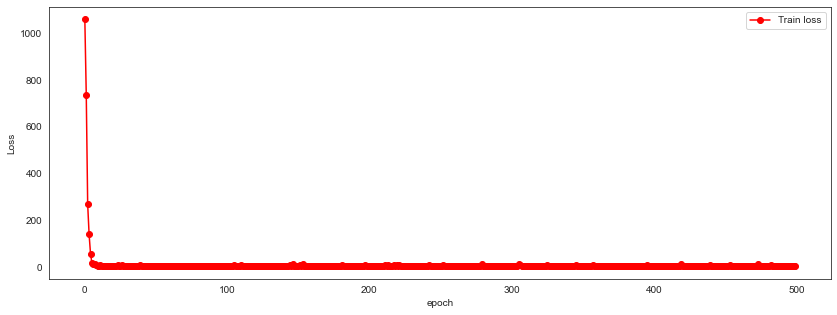

done


In [8]:
train_loss_all = []

for epoch in range(args.epochs):
    print('Epoch {}/{}'.format(epoch + 1, args.epochs))

    model.train()
    train_num = 0
    for (b_x, b_y) in data_loader:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = model(b_x)

        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += 100000 * loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(float(loss) / train_num)
    print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))


plt.figure(figsize=(14, 5))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
print('done')
torch.save(model, 'models/res_LSTM_gold.pkl')

In [9]:
dataset = PriceDataSet(X, y)
data_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)

In [10]:
df_pred = pd.read_csv(args.path).drop(columns='Unnamed: 0')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_pred[args.label] = scaler.fit_transform(df_pred[args.label].values.reshape(-1,1))
X, y = tranform_data(*create_seq_data(df_pred, args), args.seq_size, args.input_size)

In [11]:
model = model.to(torch.device('cpu'))

In [12]:
y_pred_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)

In [ ]:
y_pred = scaler.inverse_transform(y_pred_std)
y_label = scaler.inverse_transform(y.reshape(-1,1))

trainScore = mean_squared_error(y_pred, y_label, squared=True)
print('Score: %.2f RMSE' % (trainScore))

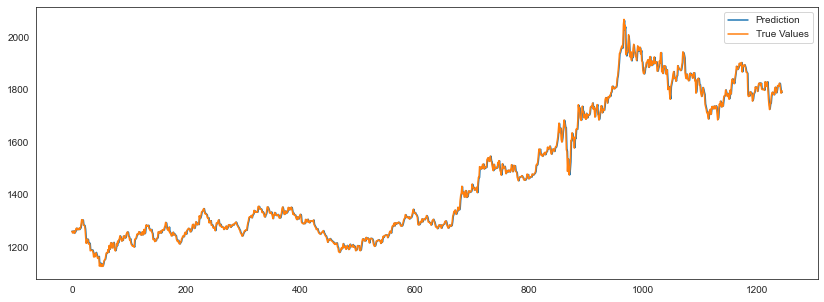

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_pred, label = 'Prediction')
plt.plot(y_label, label = 'True Values')
plt.legend()
plt.show()

In [ ]:
result = {'Price': y_label.flatten(), 'Day 1 Prediction': y_pred.flatten()}

In [ ]:
X = create_seq_data_for_day_2(df_pred[args.label].values, y_pred_std, args)

g:\2022_MCM\utils.py:175: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_feat = np.array(data_feat)


In [ ]:
pred_y_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)
y_pred = scaler.inverse_transform(pred_y_std).flatten()
mean_squared_error(result['Price'][1:], y_pred, squared=True)

388.8379623148274

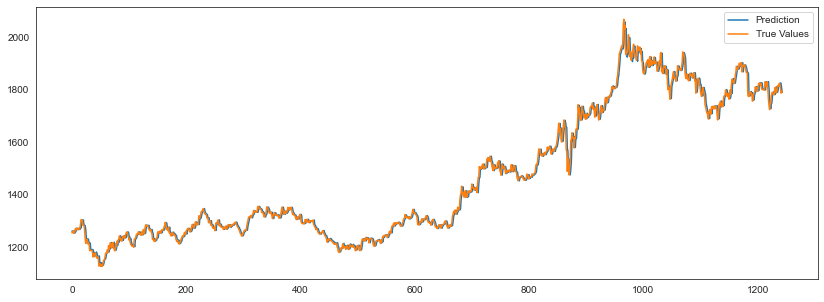

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_pred, label = 'Prediction')
plt.plot(result['Price'][1:], label = 'True Values')
plt.legend()
plt.show()

In [ ]:
result['Day 2 Prediction'] = y_pred

In [ ]:
X = create_seq_data_for_day_3(df_pred[args.label].values, scaler.transform(result['Day 1 Prediction'].reshape(-1, 1)), scaler.transform(result['Day 2 Prediction'].reshape(-1, 1)), args)

g:\2022_MCM\utils.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_feat = np.array(data_feat)


In [ ]:
pred_y_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)
y_pred = scaler.inverse_transform(pred_y_std).flatten()
mean_squared_error(result['Price'][2:], y_pred, squared=True)

599.0630525492539

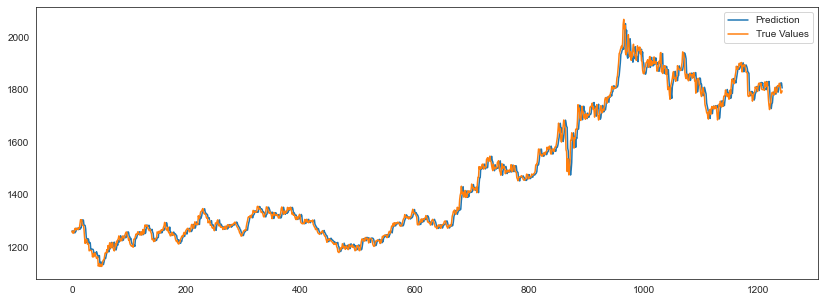

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_pred, label = 'Prediction')
plt.plot(result['Price'][2:], label = 'True Values')
plt.legend()
plt.show()

In [ ]:
result['Day 3 Prediction'] = y_pred.flatten()

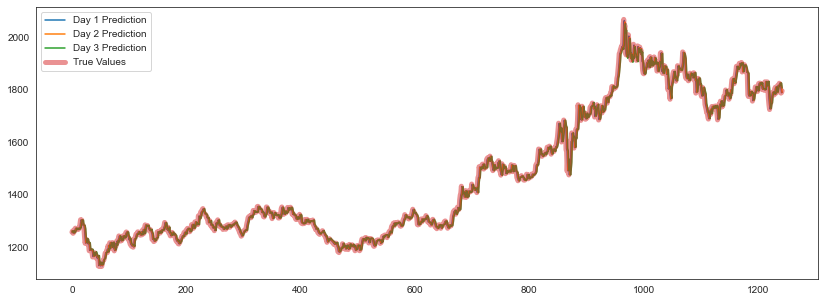

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(result['Day 1 Prediction'][2:], label = 'Day 1 Prediction')
plt.plot(result['Day 2 Prediction'][1:], label = 'Day 2 Prediction')
plt.plot(result['Day 3 Prediction'], label = 'Day 3 Prediction')
plt.plot(result['Price'][2:], label = 'True Values', linewidth = 5, alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
df_dic = {}
df_dic['Day 1 Prediction'] = result['Day 1 Prediction'][2:]
df_dic['Day 2 Prediction'] = result['Day 2 Prediction'][1:]
df_dic['Day 3 Prediction'] = result['Day 3 Prediction']
df_dic['Price'] = result['Price'][2:]
df = pd.DataFrame(df_dic)
df.to_csv('results\Price_Prediction\prediction gold price.csv')

In [ ]:
df

Day 1 Prediction  Day 2 Prediction  Day 3 Prediction    Price
0          1254.048706       1260.523926       1260.402466  1256.50
1          1256.986572       1254.586914       1260.970459  1261.05
2          1261.475952       1257.503540       1255.138916  1251.75
3          1252.387207       1261.906860       1257.994995  1254.80
4          1255.293823       1252.933838       1262.312012  1258.20
...                ...               ...               ...      ...
1238       1824.187622       1814.185669       1814.139404  1821.60
1239       1822.383057       1824.882080       1815.029297  1802.15
1240       1803.664551       1823.179199       1825.640503  1786.00
1241       1787.734863       1804.754272       1823.976196  1788.25
1242       1789.394897       1788.898560       1805.667480  1794.60

[1243 rows x 4 columns]

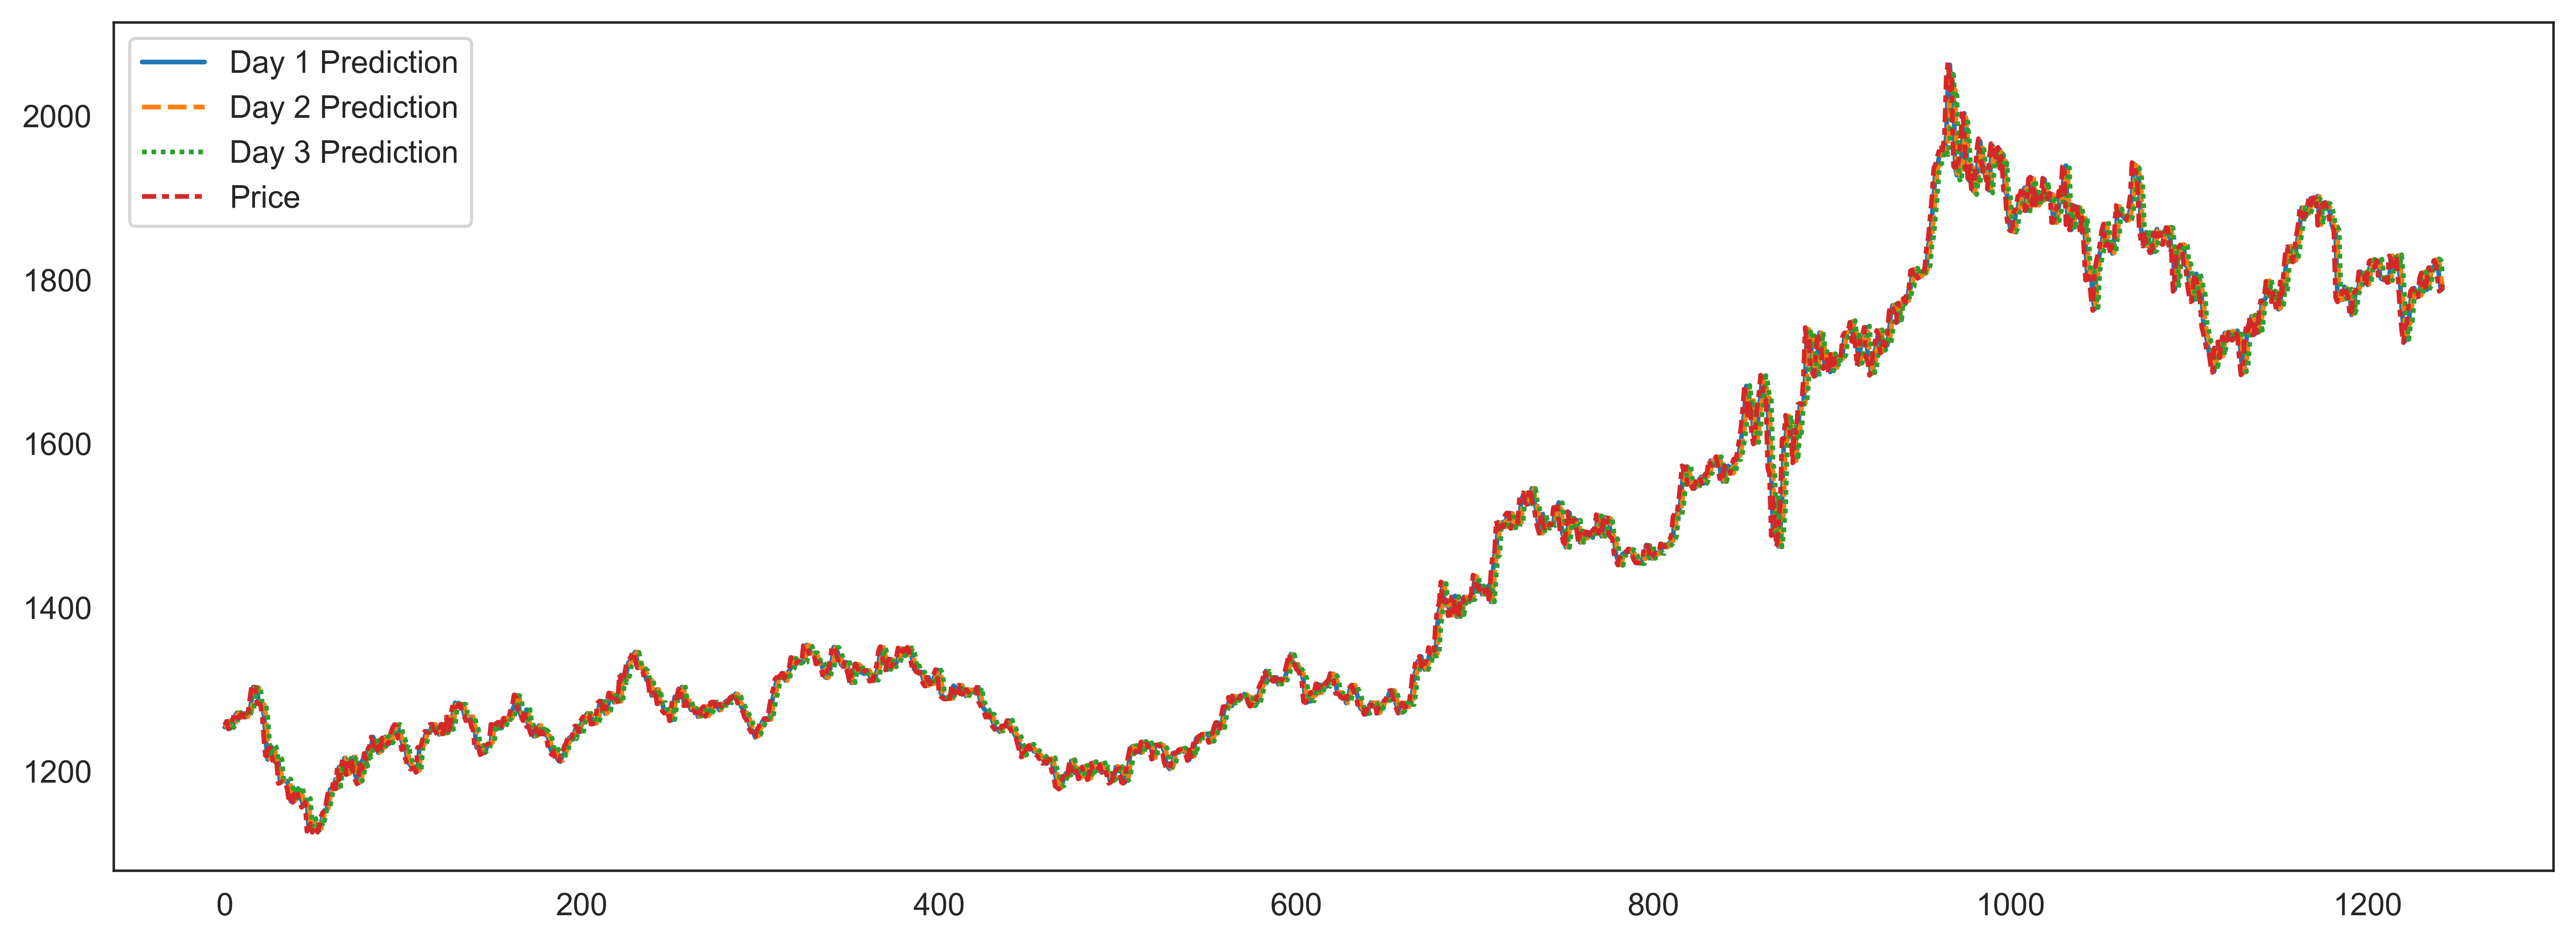

In [ ]:
plt.figure(figsize=(14, 5), dpi=500)
sns.lineplot(data=df)
plt.savefig('results\Price_Prediction/gold price prediction.jpg')

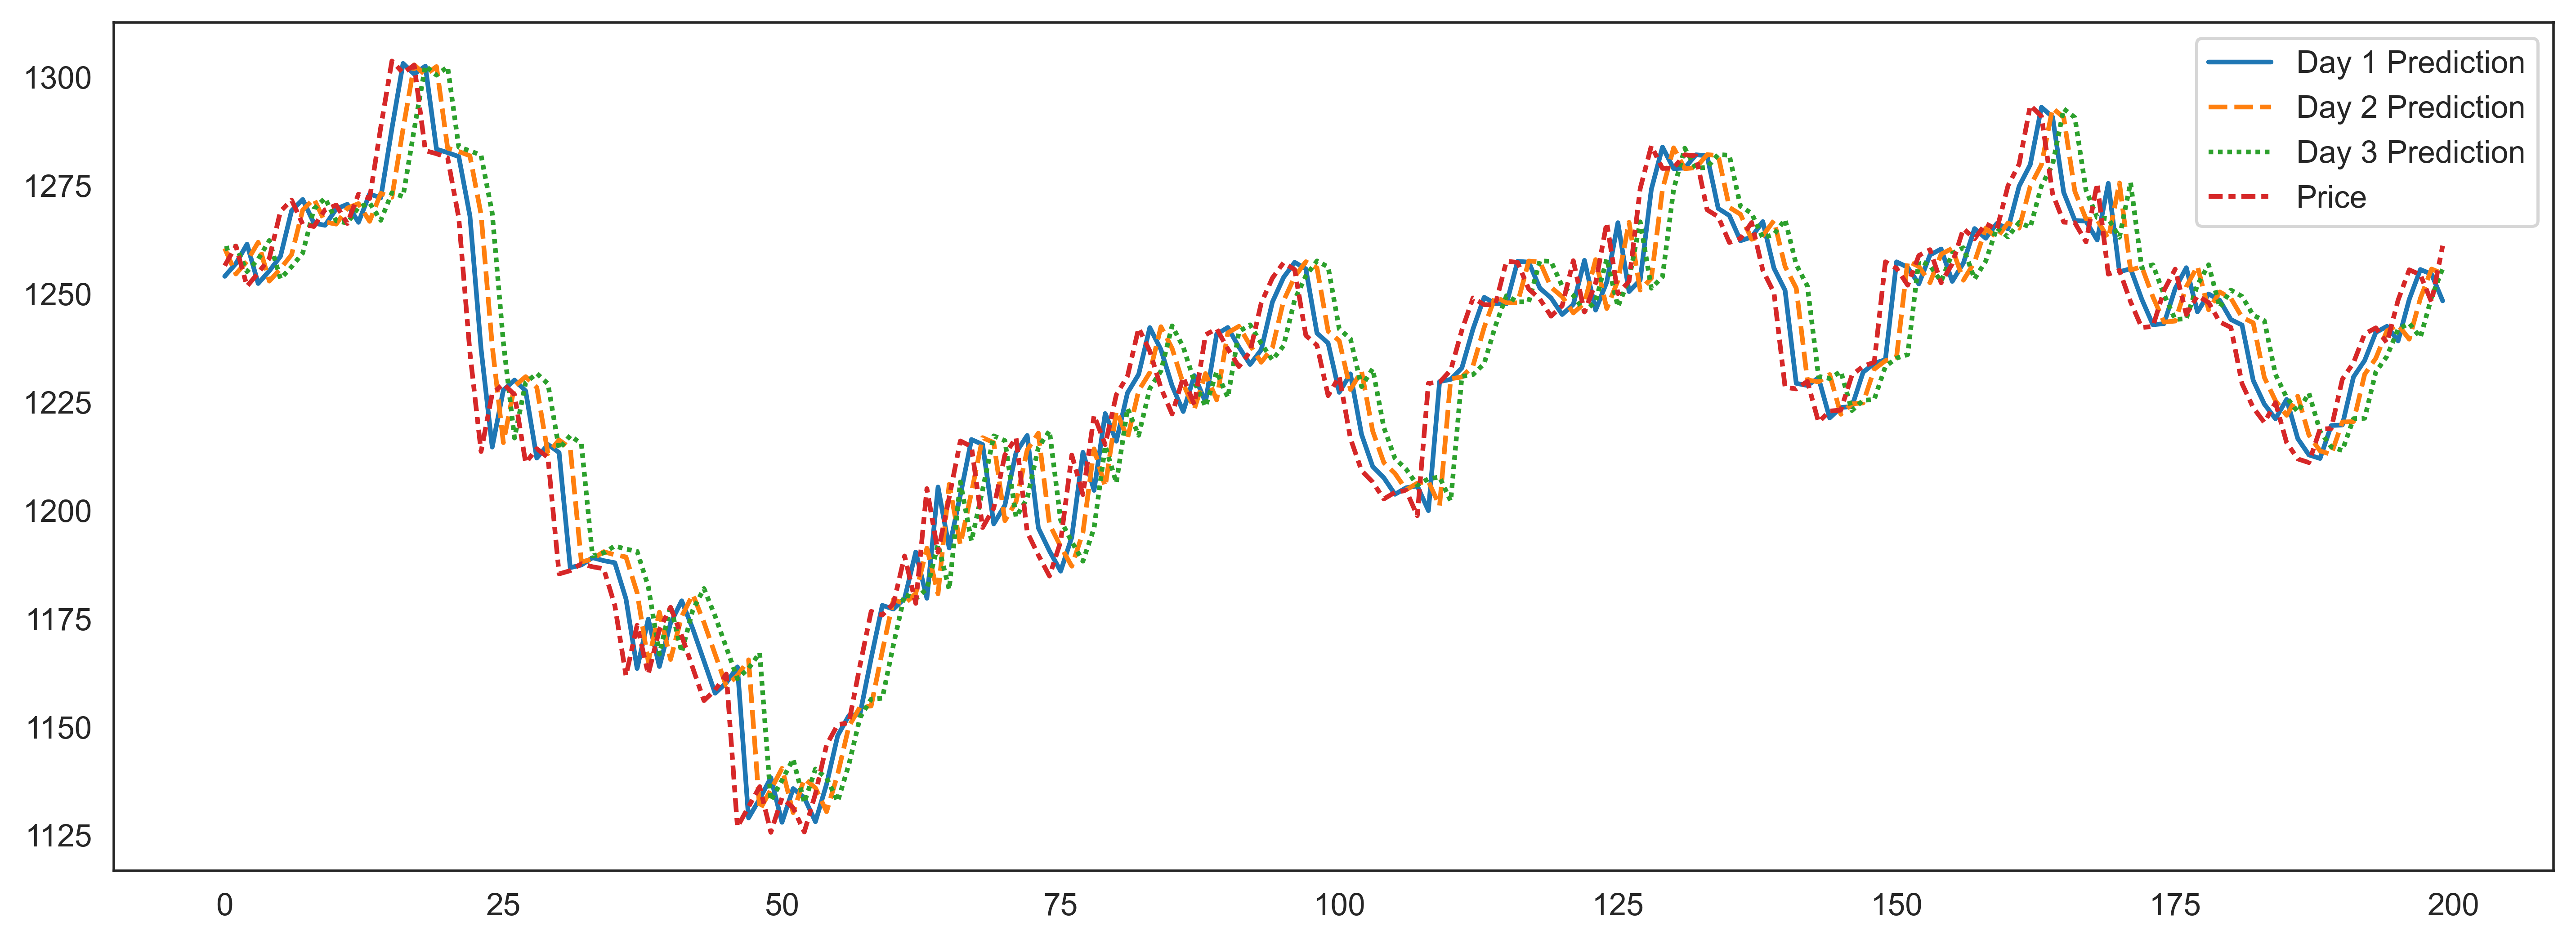

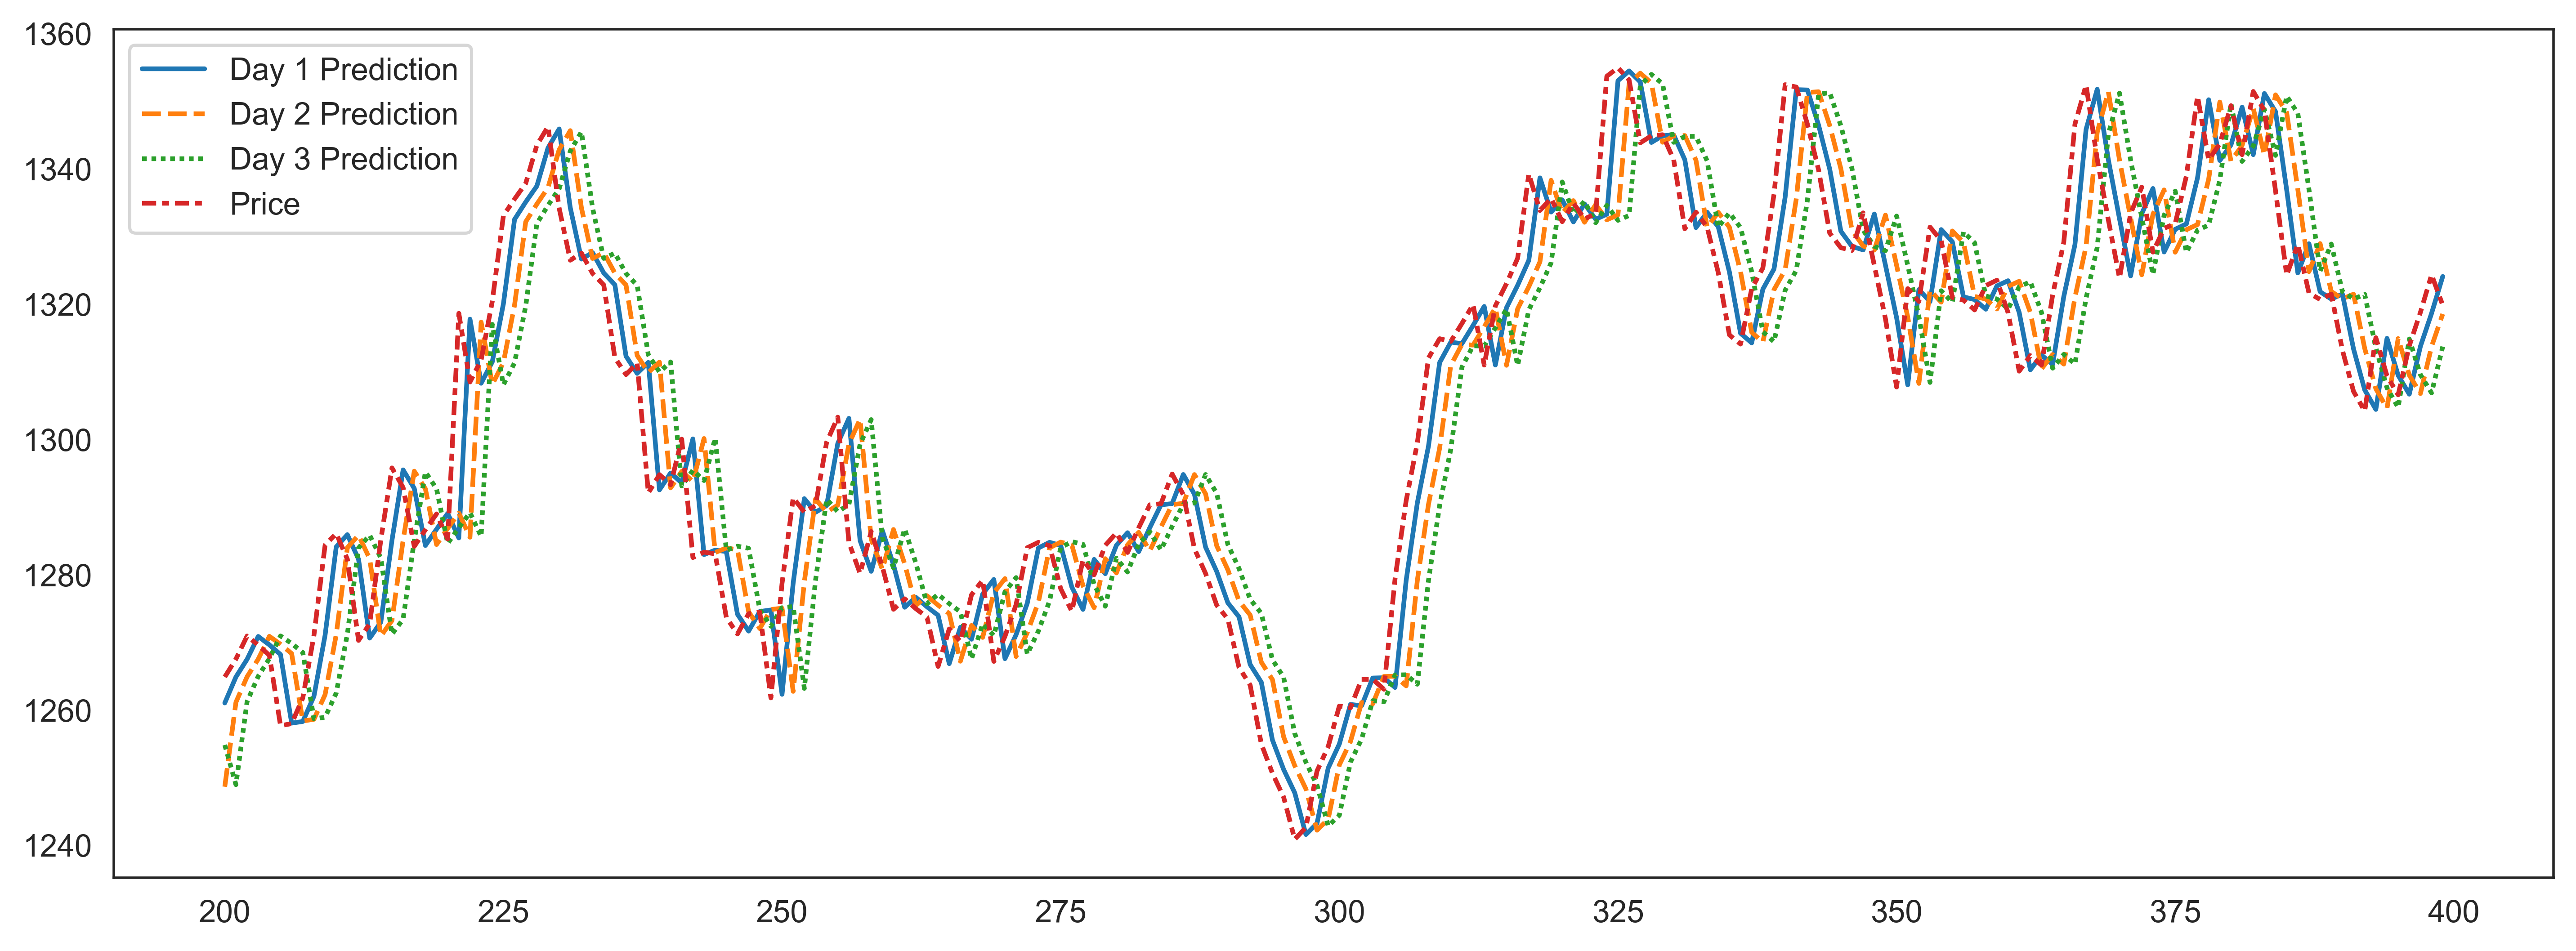

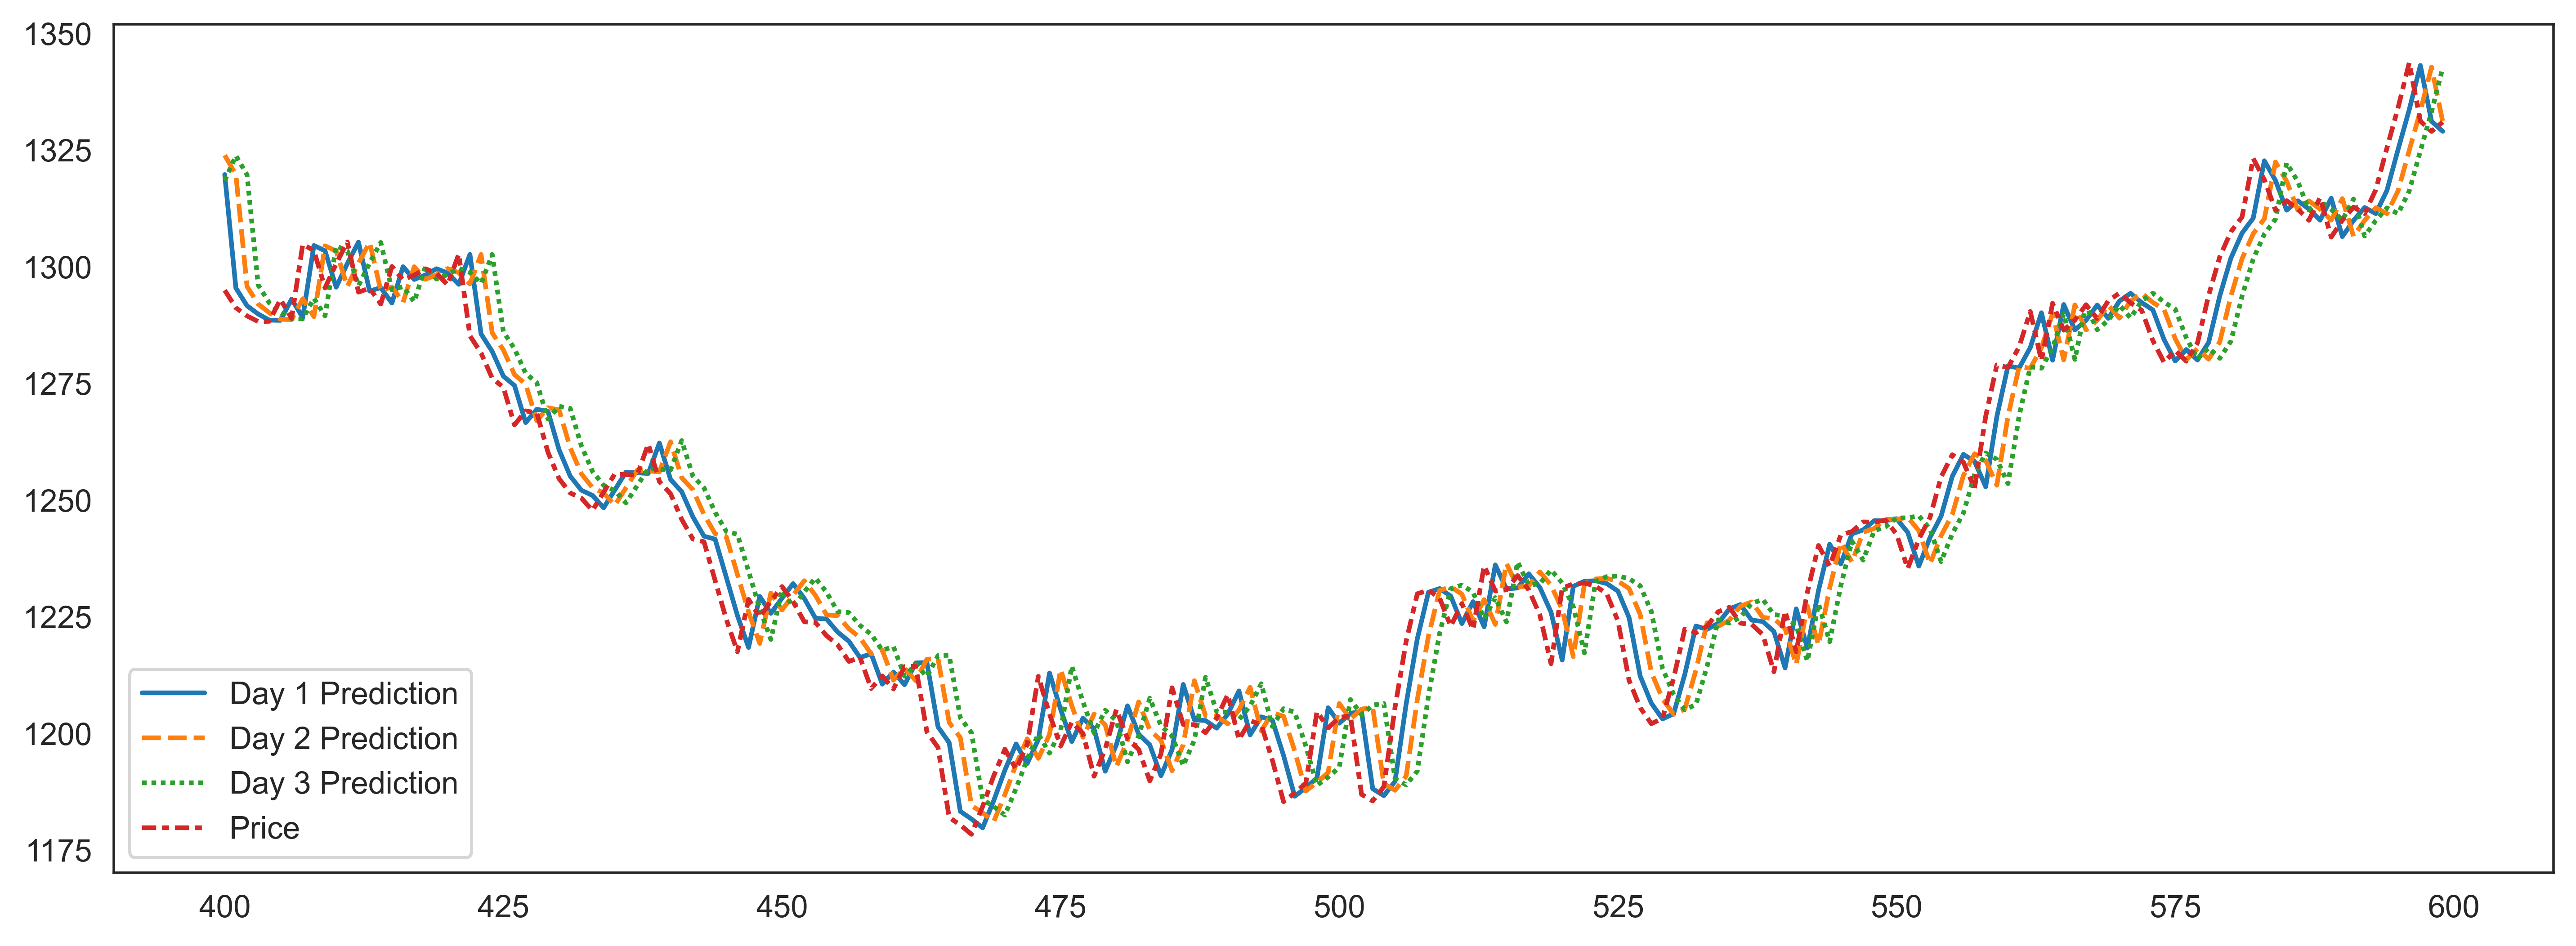

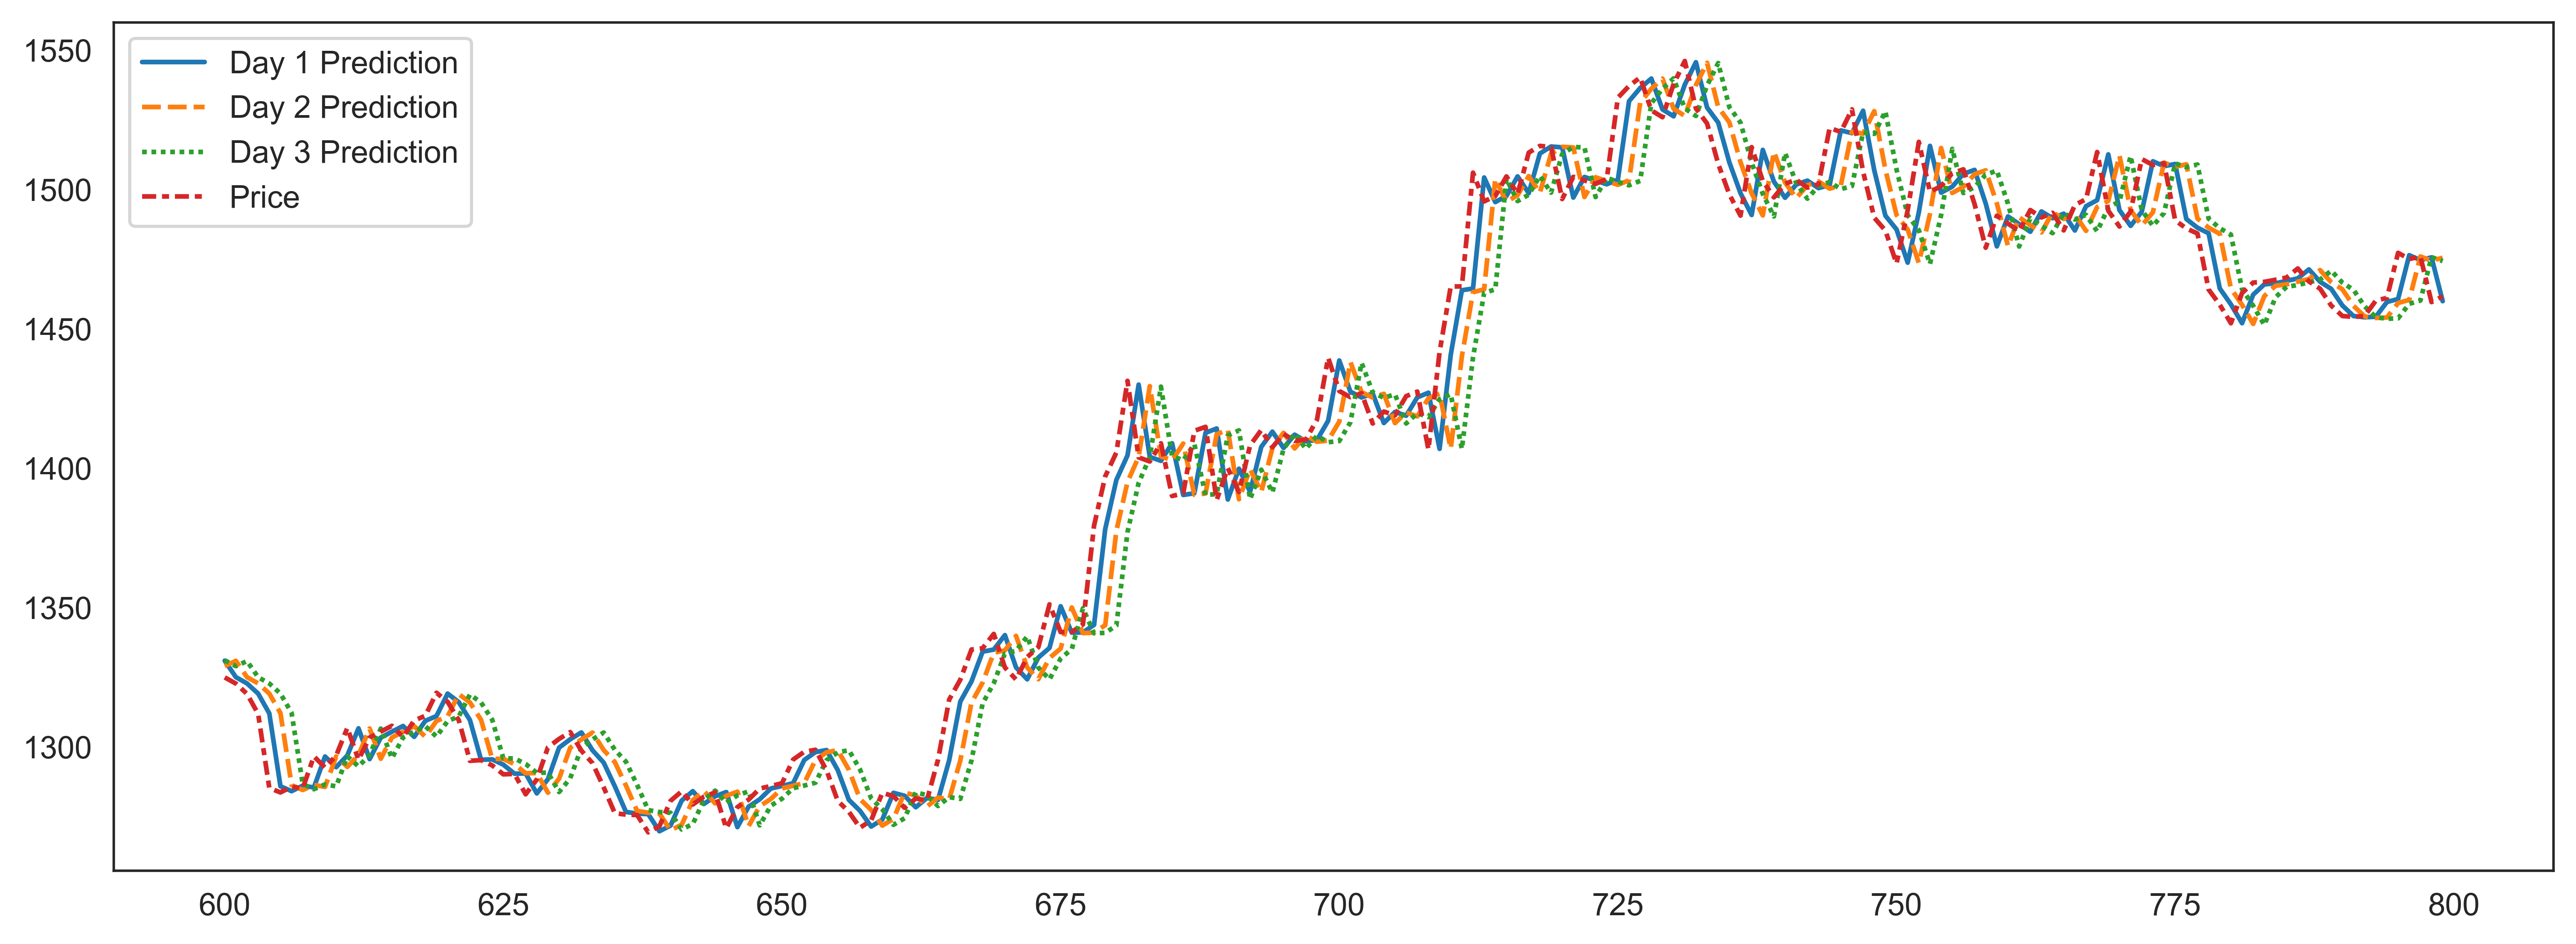

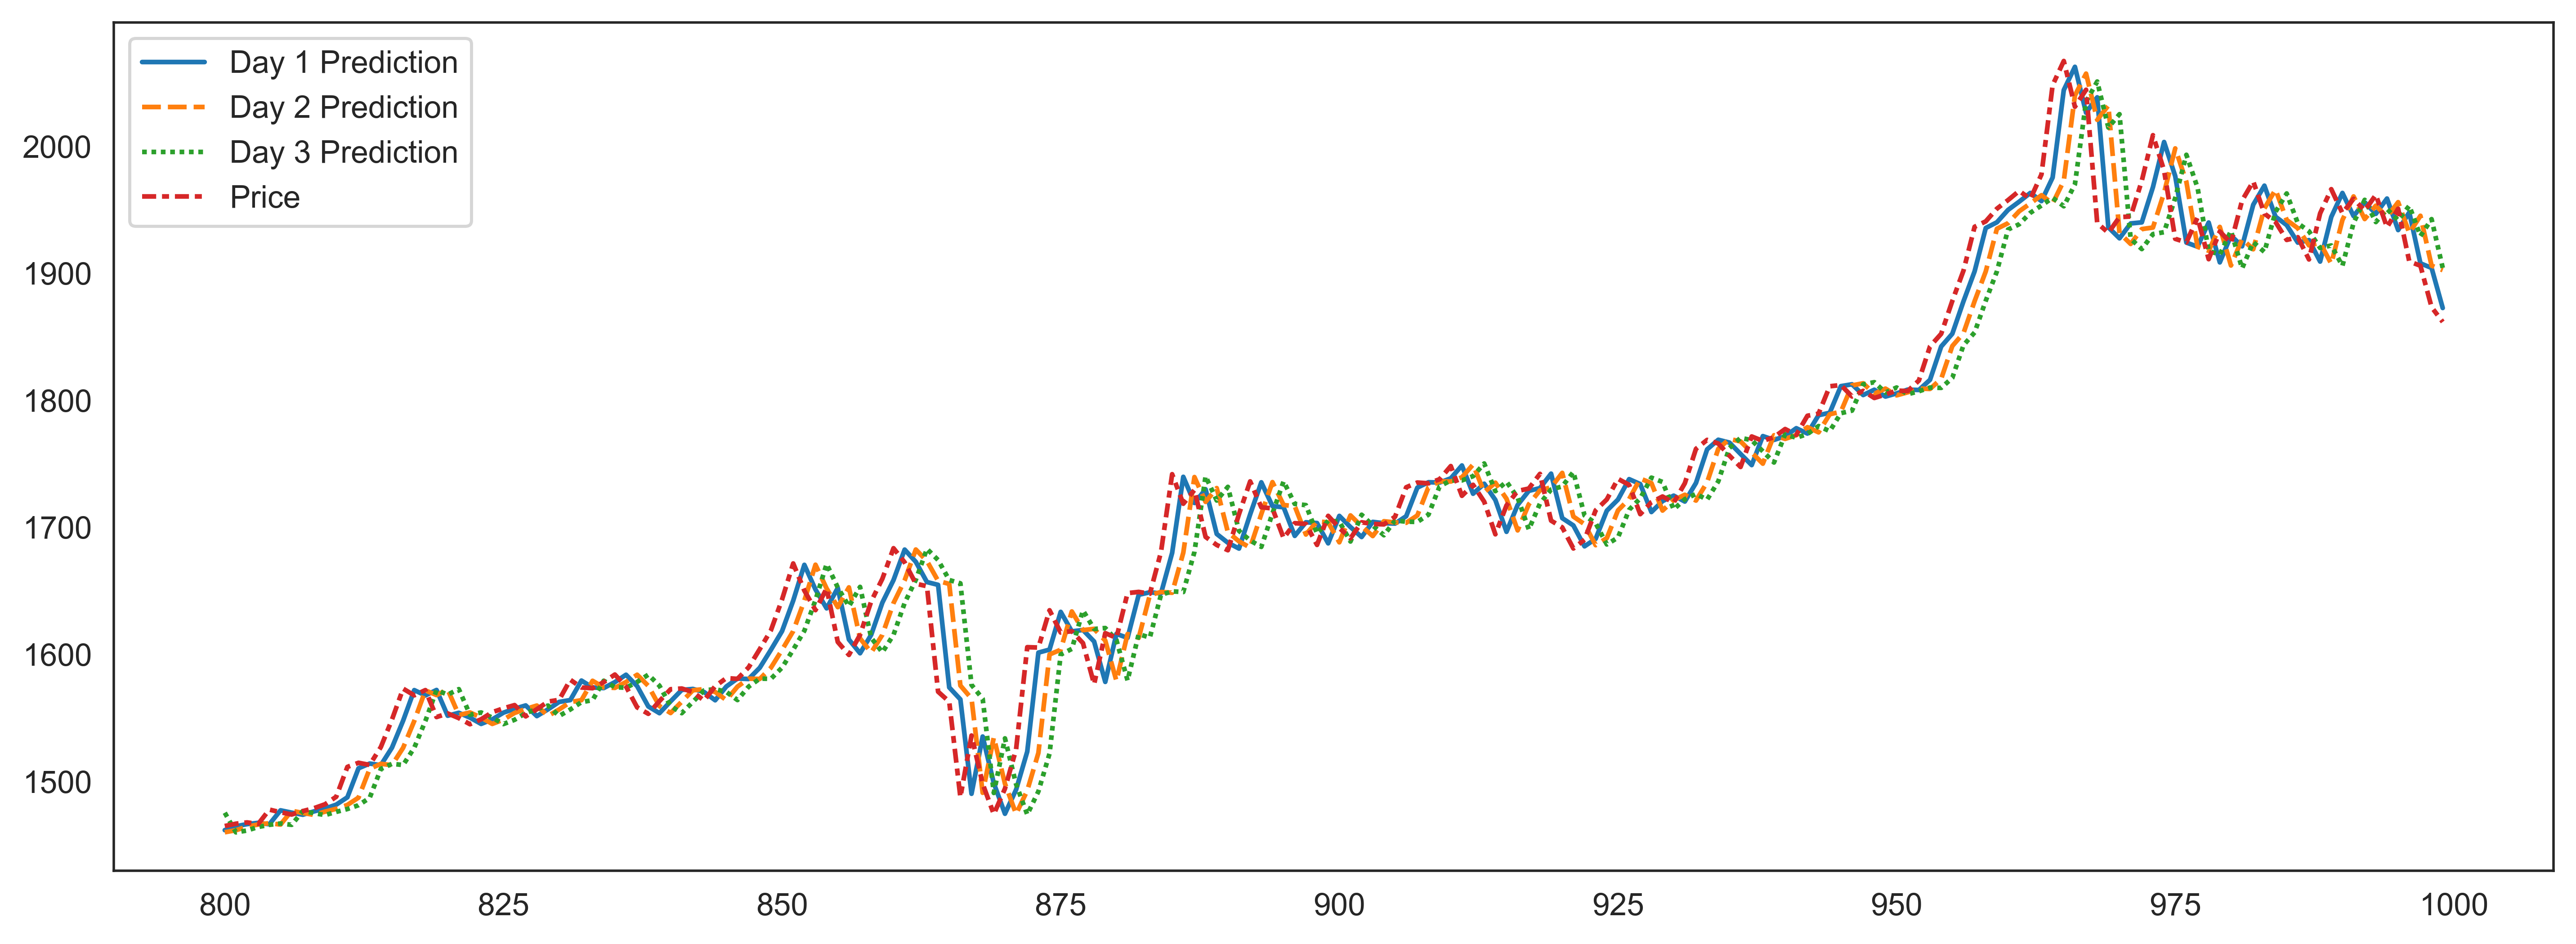

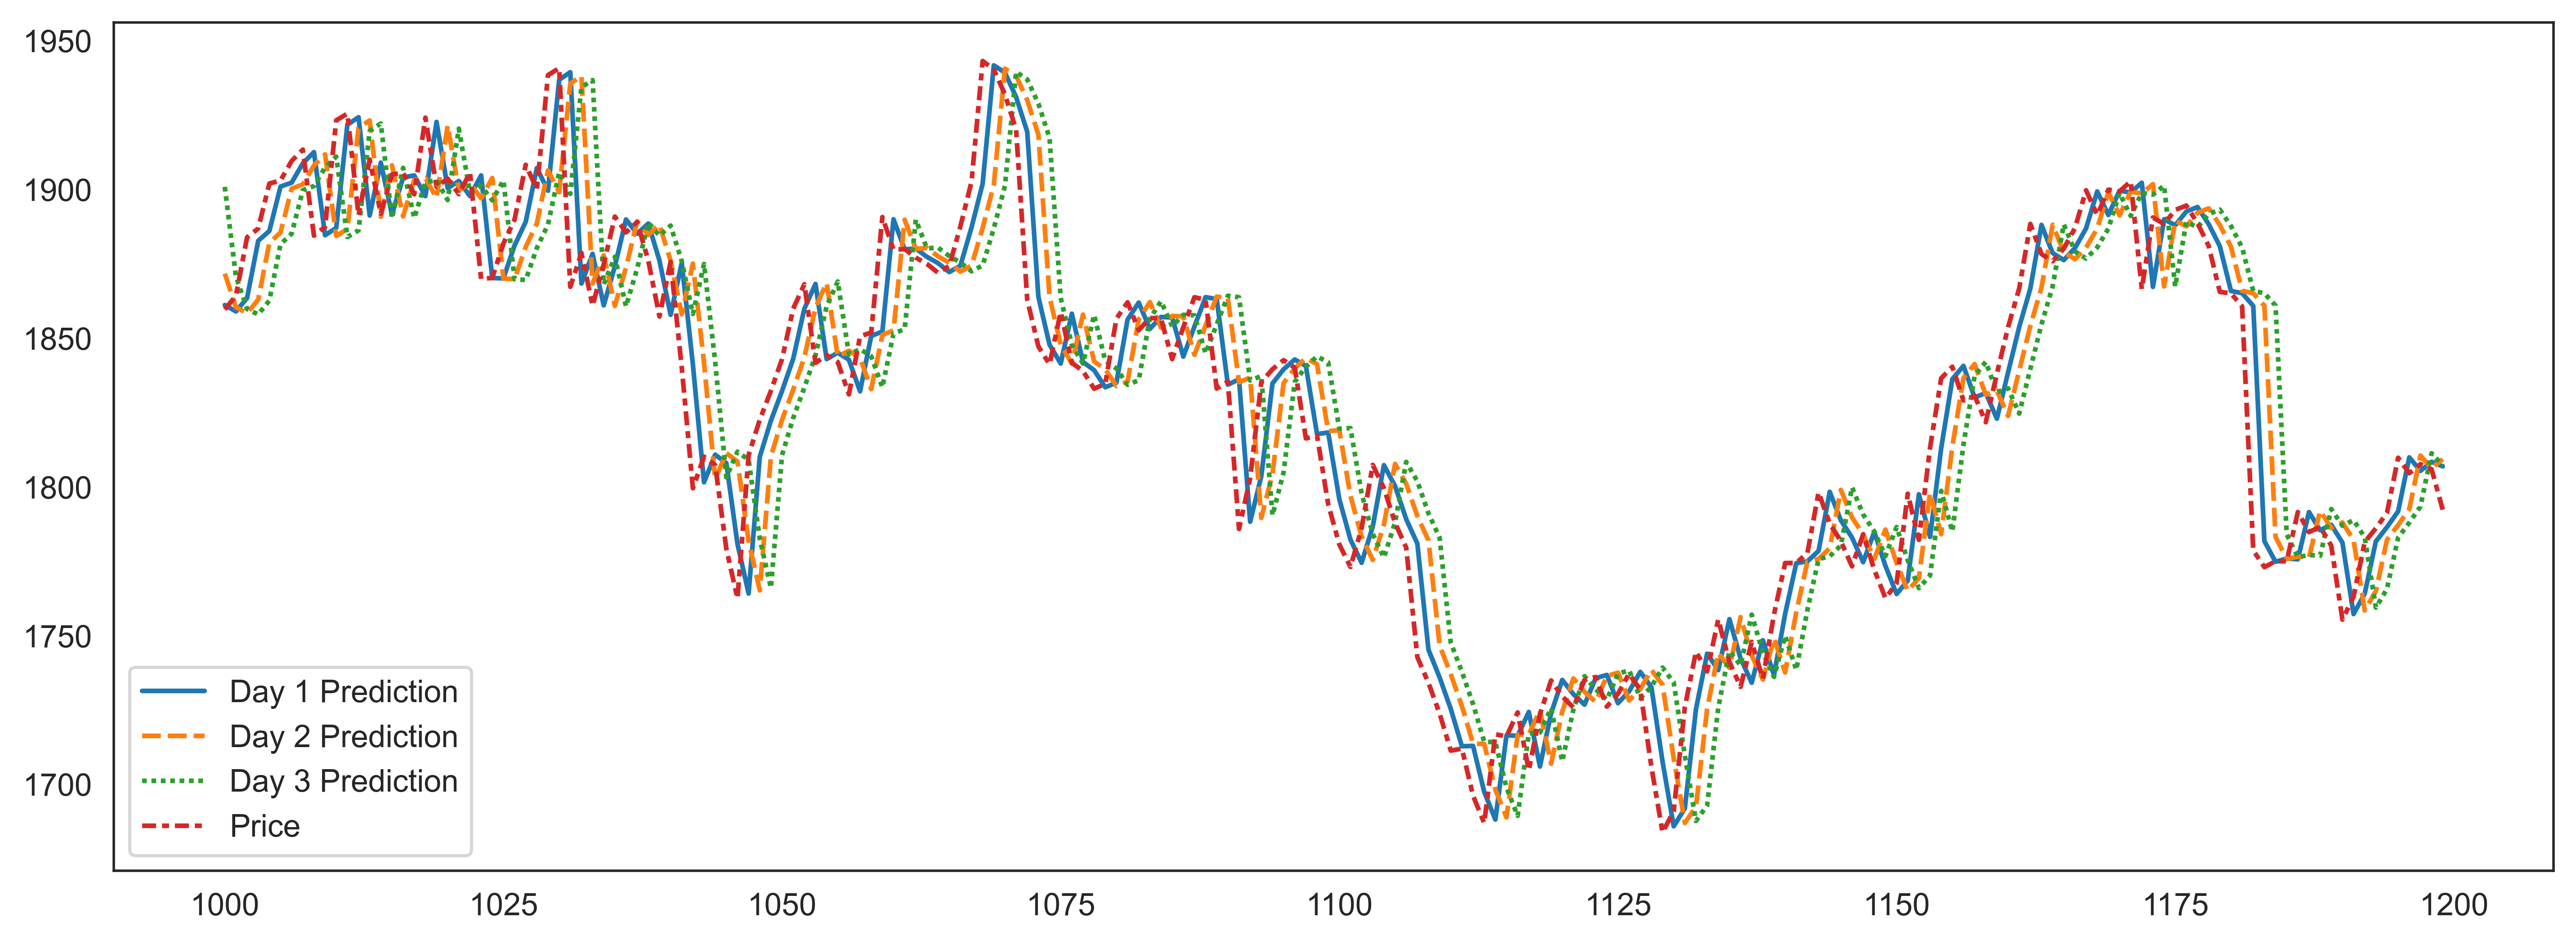

In [ ]:
interval = 200
for i in range(len(df_dic['Price']) // interval):
    plt.figure(figsize=(14, 5), dpi=500)
    sns.lineplot(data=df[i * interval: (i + 1) * interval])
    plt.savefig(f'results\Price_Prediction/gold price prediction {i}th.jpg')